# Supervised learning based model

# Setting environment

## Configuration

In [83]:
DATASET_IMAGE_SIZE = (512, 512) # the image size in dataset loaded
EMBEDDING_INPUT_SHAPE = (128, 128, 3)
BATCH_SIZE = 32

## Setting library path

In [84]:
import numpy as np
import pandas as pd
import os
import sys 

libpath = "lib"
sys.path.append(libpath)

# Importing packages

In [85]:
if "texture_dataset" in sys.modules:
    del sys.modules["texture_dataset"]

from texture_dataset import load_texture_dataset, load_texture_dataset_as_dataframe

if "dataset_viz" in sys.modules:
    del sys.modules["dataset_viz"]

from dataset_viz import plot_dataset_samples

if "split_dataset" in sys.modules:
    del sys.modules["split_dataset"]

from split_dataset import split_dataset_by_pixel, split_dataset_by_pixel_as_dataframe

if "imgaug_model" in sys.modules:
    del sys.modules["imgaug_model"]

from imgaug_model import build_augmentation_model

if "imgaug_viz" in sys.modules:
    del sys.modules["imgaug_viz"]

from imgaug_viz import plot_augmented_samples, plot_augmented_samples_for_one_image

if "supervised_model" in sys.modules:
    del sys.modules["supervised_model"]

from supervised_model import build_supervised_model, SupervisedModelDataGeneratorFromXy

# Loading MBT dataset

In [86]:
import tensorflow as tf
from tensorflow import keras

dataset_training = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture", 
                image_size = (128, 128), 
                subset="training",
                validation_split=0.2,
                batch_size = BATCH_SIZE,
                seed = 1234,
                shuffle=True
                )

#type(dataset_training)

n_classes = len(set(dataset_training.class_names))

Found 39424 files belonging to 154 classes.
Using 31540 files for training.


In [129]:
dataset = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture", 
                image_size = (128, 128), 
                #subset="training",
                #validation_split=0.2,
                batch_size = BATCH_SIZE,
                seed = 1234,
                shuffle=True
                )


#ds = ds_in.shuffle(buffer_size=rec_count)
#ds_train = ds.skip(400)
#ds_validate = ds.take(400)


Found 39424 files belonging to 154 classes.


In [133]:
n_classes = len(dataset.class_names)
#n_samples = len(dataset.file_paths)
n_samples = len(dataset) * BATCH_SIZE
n_batches = len(dataset)

print("n_classes = ", n_classes)
print("n_samples = ", n_samples)
print("n_batches = ", n_batches)

n_classes =  154
n_samples =  39424
n_batches =  1232


In [134]:
dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=1232>

In [119]:
dataset = dataset.shuffle(buffer_size = n_batches)

In [153]:
#
#    80% (training) + 20% (test)
#
# we keep 80% of the dataset as training
n_training_batches = np.int(0.8 * n_batches)
dataset_training = dataset.take(n_training_batches)

# we keep 10% of the dataset as testing
n_testing_batches = n_batches - n_training_batches
dataset_testing = dataset.skip(n_training_batches).take(n_testing_batches)

print("n_training_batches = ", n_training_batches)
print("n_testing_batches = ", n_testing_batches)

n_training_batches =  985
n_testing_batches =  247


In [154]:
from tensorflow.keras.applications.vgg16 import preprocess_input

dataset_training = dataset_training.map(
              lambda x, y: (preprocess_input(x), y)
            )

dataset_testing = dataset_training.map(
              lambda x, y: (preprocess_input(x), y)
            )


In [155]:
for data, labels in dataset_training.take(1):
    print(data.shape)
    print(labels.shape)

(32, 128, 128, 3)
(32,)


In [77]:
import matplotlib.pyplot as plt
 
#class_names = dataset_training.class_names
#plt.figure(figsize=(10, 10))
#for images, labels in dataset_training.take(1):
#    for i in range(9):
#        ax = plt.subplot(3, 3, i + 1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

# Training

## Possible chopping layers at base encoder model

- conv2_block1_out
- conv2_block2_out
- conv2_block3_out

- conv3_block1_out
- conv3_block2_out
- conv3_block3_out
- conv3_block4_out

- conv4_block1_out
- conv4_block2_out
- conv4_block3_out
- conv4_block4_out
- conv4_block5_out
- conv4_block6_out

- conv5_block1_out
- conv5_block2_out
- conv5_block3_out

## Results

ResNet50:
- conv2_block3_out training 86% testing 22%
- conv3_block4_out 86% 12%
- conv4_block6_out xx%
- conv5_block3_out training 70% testing 13%

MobileNet:
- 51% testing accuracy (100 epochs)
- 79% training accuracy (100 epochs)

VGG16
- 69% training
- 75% testing

## Chopping at last layer

In [156]:
#n_classes = len(set(dataset_training.class_names))

model_1 = build_supervised_model(
                               embedding_input_shape = EMBEDDING_INPUT_SHAPE, 
                               n_classes = n_classes, 
                               #chopping_layer = "conv2_block3_out",
                               #learning_rate = 0.001,
                               finetune = False,
                                )

embedding_input_shape =  (128, 128, 3)
newhead_input_shape =  (512,)
DENSE_DIMS =  (308, 231)


In [ ]:
history_1 = model_1.fit(
                    dataset_training, 
                    epochs = 50, 
                    steps_per_epoch=10,
                    verbose = 1,
                    #validation_steps = 10 * 5,
                    #validation_data = dataset_val,
                 ) 

Epoch 1/50
10/10 [==============================] - 15s 1s/step - loss: 4.7583 - accuracy: 0.0844
Epoch 2/50
10/10 [==============================] - 16s 2s/step - loss: 3.5751 - accuracy: 0.2375
Epoch 3/50
 1/10 [==>...........................] - ETA: 12s - loss: 3.7462 - accuracy: 0.1875

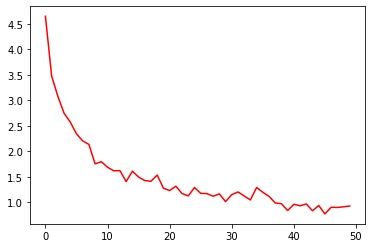

In [95]:
import matplotlib.pyplot as plt

loss_hist_1 = history_1.history["loss"]

plt.plot(loss_hist_1, c = 'red')
plt.show()

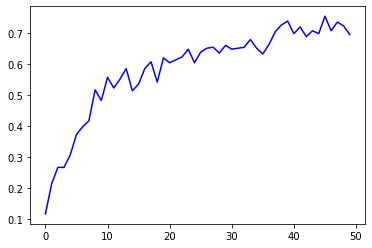

In [96]:
acc_hist_1 = history_1.history["accuracy"]
plt.plot(acc_hist_1, c = 'blue')
plt.show()

In [97]:
model_1.save("models/supervised_model_1.saved_model")

INFO:tensorflow:Assets written to: models/supervised_model_1.saved_model/assets


In [98]:
result_1 = model_1.evaluate(dataset_val)

247/247 [==============================] - 374s 2s/step - loss: 0.8492 - accuracy: 0.7336


## Chopping at "conv2_block3_out"

In [105]:
n_classes = len(y)

model_2 = build_supervised_model(
                               embedding_input_shape = EMBEDDING_INPUT_SHAPE, 
                               n_classes = n_classes, 
                               chopping_layer = "conv2_block3_out",
                               #learning_rate = 0.001,
                               finetune = True,
                                )

embedding_input_shape =  (128, 128, 3)
newhead_input_shape =  (256,)
DENSE_DIMS =  (308, 231)


In [107]:
history_2 = model_2.fit(
                    train_generator, 
                    epochs = 100, 
                    steps_per_epoch=10,
                    verbose = 1,
                 ) 

Epoch 1/100
10/10 [==============================] - 22s 1s/step - loss: 8.3198 - accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 21s 1s/step - loss: 6.0656 - accuracy: 0.0375
Epoch 3/100
10/10 [==============================] - 23s 2s/step - loss: 5.3288 - accuracy: 0.0375
Epoch 4/100
10/10 [==============================] - 21s 2s/step - loss: 5.0442 - accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 21s 2s/step - loss: 5.0103 - accuracy: 0.0125
Epoch 6/100
10/10 [==============================] - 21s 2s/step - loss: 4.9974 - accuracy: 0.0500
Epoch 7/100
10/10 [==============================] - 21s 1s/step - loss: 4.7807 - accuracy: 0.1000
Epoch 8/100
10/10 [==============================] - 21s 2s/step - loss: 4.8841 - accuracy: 0.0375
Epoch 9/100
10/10 [==============================] - 21s 1s/step - loss: 4.8308 - accuracy: 0.0500
Epoch 10/100
10/10 [==============================] - 21s 2s/step - loss: 4.8948 - accuracy: 0.0500
E

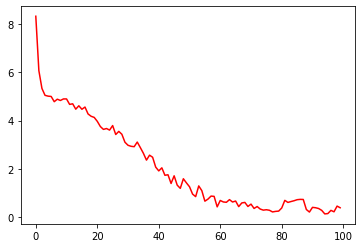

In [108]:
import matplotlib.pyplot as plt

loss_hist_2 = history_2.history["loss"]
plt.plot(loss_hist_2, c = 'red')
plt.show()


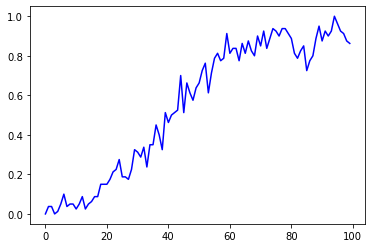

In [118]:
acc_hist_2 = history_2.history["accuracy"]
plt.plot(acc_hist_2, c = 'blue')
plt.show()

In [109]:
model_2.save("models/supervised_model_2.saved_model")

/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/supervised_model_2.saved_model/assets


In [110]:
result_2 = model_2.evaluate(test_generator)

128/128 [==============================] - 55s 427ms/step - loss: 3.1999 - accuracy: 0.2178


## Chopping at "conv3_block4_out"

In [113]:

n_classes = len(y)

model_3 = build_supervised_model(
                               embedding_input_shape = EMBEDDING_INPUT_SHAPE, 
                               n_classes = n_classes, 
                               chopping_layer = "conv3_block4_out",
                               #learning_rate = 0.001,
                               finetune = True,
                                )

embedding_input_shape =  (128, 128, 3)
newhead_input_shape =  (512,)
DENSE_DIMS =  (308, 231)


In [114]:
history_3 = model_3.fit(
                    train_generator, 
                    epochs = 100, 
                    steps_per_epoch=10,
                    verbose = 1,
                 ) 

Epoch 1/100
10/10 [==============================] - 33s 2s/step - loss: 9.2984 - accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 31s 2s/step - loss: 5.9687 - accuracy: 0.0125
Epoch 3/100
10/10 [==============================] - 34s 3s/step - loss: 5.4108 - accuracy: 0.0250
Epoch 4/100
10/10 [==============================] - 33s 3s/step - loss: 4.8865 - accuracy: 0.0625
Epoch 5/100
10/10 [==============================] - 43s 3s/step - loss: 4.7877 - accuracy: 0.1250
Epoch 6/100
10/10 [==============================] - 36s 3s/step - loss: 4.9147 - accuracy: 0.0500
Epoch 7/100
10/10 [==============================] - 37s 3s/step - loss: 4.7843 - accuracy: 0.0750
Epoch 8/100
10/10 [==============================] - 38s 3s/step - loss: 4.6226 - accuracy: 0.1125
Epoch 9/100
10/10 [==============================] - 32s 3s/step - loss: 4.3123 - accuracy: 0.1500
Epoch 10/100
10/10 [==============================] - 31s 3s/step - loss: 4.2544 - accuracy: 0.1375
Epoch

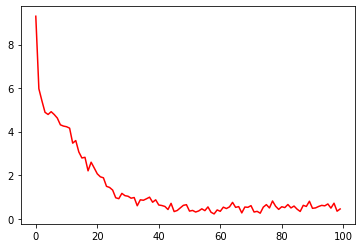

In [119]:
import matplotlib.pyplot as plt

loss_hist_3 = history_3.history["loss"]
plt.plot(loss_hist_3, c = 'red')
plt.show()

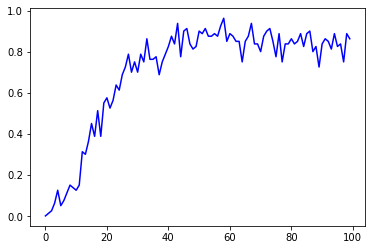

In [120]:
acc_hist_3 = history_3.history["accuracy"]
plt.plot(acc_hist_3, c = 'blue')
plt.show()

In [121]:
result_3 = model_3.evaluate(test_generator)

128/128 [==============================] - 96s 743ms/step - loss: 5.0272 - accuracy: 0.1221


## Chopping at "conv4_block6_out"

In [ ]:
n_classes = len(y)

model_4 = build_supervised_model(
                               embedding_input_shape = EMBEDDING_INPUT_SHAPE, 
                               n_classes = n_classes, 
                               chopping_layer = "conv4_block6_out",
                               #learning_rate = 0.001,
                               finetune = True,
                                )

In [ ]:
history_4 = model_4.fit(
                    train_generator, 
                    epochs = 100, 
                    steps_per_epoch=10,
                    verbose = 1,
                 ) 

In [ ]:
import matplotlib.pyplot as plt

loss_hist_4 = history_4.history["loss"]

plt.plot(loss_hist_4, c = 'red')
plt.show()

In [ ]:
result_4 = model_4.evaluate(test_generator)

# Training fine-tuning

In [ ]:
train_history_finetuned = model_finetuned.fit(
                    train_generator, 
                    epochs = 100, 
                    steps_per_epoch=10,
                    verbose = 1,
                    batch_size = batch_size,
                    #validation_data = val_generator,
                 ) 

In [ ]:
model_finetuned.save("models/supervised_model_finetuned.saved_model")